<a href="https://colab.research.google.com/github/mohanveeramanikantak/FMML/blob/main/Module_9%20Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 3**


## 1. Understanding Convolutions

---



<img src="https://miro.medium.com/max/464/0*e-SMFTzO8r7skkpc" width=650px/>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing some pytorch packages
import torch
from torch.nn import Conv2d

Central to CNNs, a convolution operation is a linear element-wise multiplication operation between a small filter/kernel and same-sized patch from the image. We move this filter over the image like a sliding window from top left to bottom right. For each point on the image, a value is calculated based on the filter using a convolution operation. These filters can do simplest task like checking if there is a vertical line in the image or complicated task like detecting a human eye in the image.

Let's look at the convolution formula:

Convolution between image
$f(x, y)$ and kernel $k(x, y)$ is
$$f(x,y) * k(x,y) = \sum \limits _{i=0} ^{W-1} \sum \limits _{j=0} ^{H-1} f(i, j) k(x − i, y − j)$$

where $W$ and $H$ are the the width and height of the image.

The code demonstrates the convolution operation of a 2D matrix (image) with various filters

<img src="https://www.researchgate.net/profile/Chaim-Baskin/publication/318849314/figure/fig1/AS:614287726870532@1523469015098/Image-convolution-with-an-input-image-of-size-7-7-and-a-filter-kernel-of-size-3-3.png" alt="Convolution" width=650px height=280px/>

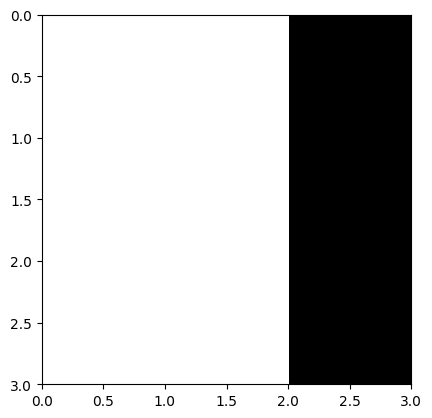

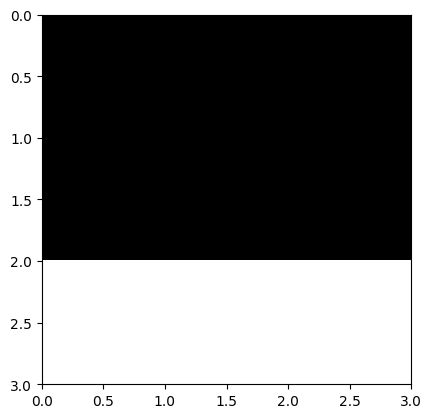

In [3]:
# 2D 3x3 binary image with vertical edge
image1 = np.array([[1,1,0], [1,1,0], [1,1,0]])

# 2D 3x3 binary image with horizontal edge
image2 = np.array([[0,0,0], [0,0,0], [1,1,1]])

# On plotting the images
plt.imshow(image1, cmap='gray', extent=[0, 3, 3, 0])
plt.show()
plt.imshow(image2, cmap='gray', extent=[0, 3, 3, 0])
plt.show()

In [4]:
# Vertical Line filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

# Applying filter to first image
output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

# Applying filter to second image
output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  3
Output from second image:  0


In [5]:
# Horizontal edge filter
filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  0
Output from second image:  3


Non-zero output suggests that there is a vertical edge present in the first image and not present in the second image. Similarly, horizontal edge is detected in second.

Let's define a function to use convolution layer from Pytorch and use our own kernel to detect edges in image

In [6]:
def apply_conv(image, kernel, padding=0, stride=1):

  #--------IMAGE PREPROCESSING-------
  image = torch.from_numpy(image)
  # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
  input = image.view((1,1,image.shape[0], image.shape[1]))

  # --------------KERNEL-------------
  kernel = torch.from_numpy(kernel.astype(np.float32))

  # Pytorch requires kernel of shape (N,C,H,W), where N = batch size and C=#channels in input
  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))

  # ---------CONVOLUTION LAYER from Pytorch--------
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)

  # Set the kernel weights in the convolution layer
  conv.weight = torch.nn.Parameter(kernel)

  # ---------APPLY CONVOLUTION--------
  output = conv(input.float())
  output_img = output.data.numpy()  # Tensor to back in numpy
  output_img = output_img.reshape((-1, output_img.shape[-1])) # Reshape to 2D image

  return output_img

In [7]:

# Our original lotus image
image = cv2.imread('grid1.jpg', 0)

# Check if image loading was successful
if image is None:
    print("Error: Could not load image. Please check the file path.")
else:
    filter = np.array([[-1, -1, -1],
                       [0, 0, 0],
                       [1, 1, 1]])

    out1 = apply_conv(image, filter, padding=0, stride=1)

    filter = np.array([[1, 0, -1],
                       [1, 0, -1],
                       [1, 0, -1]])

    out2 = apply_conv(image, filter, padding=0, stride=1)

Error: Could not load image. Please check the file path.


## Pooling Layers

Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network. The pooling layer summarises the features present in a region of the feature map generated by a convolution layer.

1) Max Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721025744/Screenshot-2019-07-21-at-2.57.13-AM.png' height=150px/>

2) Average Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721030705/Screenshot-2019-07-21-at-3.05.56-AM.png' height=150px/>

## Softmax layer/activation
Recall that logistic regression produces a decimal between 0 and 1.0. For example, a logistic regression output of 0.8 from an email classifier suggests an 80% chance of an email being spam and a 20% chance of it being not spam. Clearly, the sum of the probabilities of an email being either spam or not spam is 1.0.

Softmax extends this idea into a multi-class world. That is, Softmax assigns decimal probabilities to each class in a multi-class problem. Those decimal probabilities must add up to 1.0. This additional constraint helps training converge more quickly than it otherwise would.
Softmax is implemented through a neural network layer just before the output layer. The Softmax layer must have the same number of nodes as the output layer.

<img src='https://miro.medium.com/max/1400/1*ReYpdIZ3ZSAPb2W8cJpkBg.jpeg' height=170px />

## Learning to train a CNN network

In [8]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [9]:
#  Images returned from torchvision dataset classes is in range [0,1]
# We transform them to tensors and normalize them to range [-1,1] using 'Normalize' transform

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 47.3MB/s]


In [10]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [11]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [12]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

In [13]:
# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [15]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

In [ ]:
#(), lr:=0.05, momentum=0.9
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [16]:
num_epochs = 5
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer) # Changed 'critertion' to 'criterion'

NameError: name 'optimizer' is not defined

In [ ]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define the CNN Model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)          # Input: 3x32x32 -> Output: 16x30x30
        self.pool = nn.MaxPool2d(2, 2)            # Output: 16x15x15
        self.conv2 = nn.Conv2d(16, 32, 5)         # Output: 32x11x11
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)             # Output for 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))      # After conv1 & pool
        x = self.pool(F.relu(self.conv2(x)))      # After conv2 & pool
        x = torch.flatten(x, 1)                   # Flatten the output
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training function
def train(num_epochs, model, train_loader, loss_func, optimizer):
    model.train()
    train_losses = []
    train_acc = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(images)
            loss = loss_func(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(output, 1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_correct / total

        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)

        print('Epoch {}/{} | Loss: {:.4f} | Accuracy: {:.2f}%'.format(
            epoch + 1, num_epochs, epoch_loss, epoch_acc * 100))

    return train_losses, train_acc

# Test function
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Test Accuracy of the network: {:.2f}%'.format(100 * correct / total))


# -----------------------------------------------
# CIFAR-10 Dataset Loading
# -----------------------------------------------
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# -----------------------------------------------
# Model, Loss, Optimizer
# -----------------------------------------------
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

# -----------------------------------------------
# Train the model
# -----------------------------------------------
num_epochs = 5
train_losses, train_acc = train(num_epochs, model, train_loader, criterion, optimizer)

# -----------------------------------------------
# Test the model
# -----------------------------------------------
test_model(model, test_loader)

# -----------------------------------------------
# Plotting training loss and accuracy
# -----------------------------------------------
plt.figure(figsize=(10, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Loss vs Epochs')

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(train_acc) + 1), [acc * 100 for acc in train_acc], marker='o')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy (%)')
plt.title('Accuracy vs Epochs')

plt.tight_layout()
plt.show()

Epoch 1/5 | Loss: 1.7244 | Accuracy: 37.06%


In [ ]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# ... (Your existing code for Net class, train function, and test_model function) ...

# Create an instance of the model
model = Net()  # Define the model before using it

# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

# ... (Rest of your training and testing code) ...

Epoch 1/5 | Loss: 1.6638 | Accuracy: 39.31%
Epoch 2/5 | Loss: 1.1858 | Accuracy: 58.31%
Epoch 3/5 | Loss: 0.9918 | Accuracy: 65.08%
Epoch 4/5 | Loss: 0.8447 | Accuracy: 70.48%
Epoch 5/5 | Loss: 0.7247 | Accuracy: 74.52%


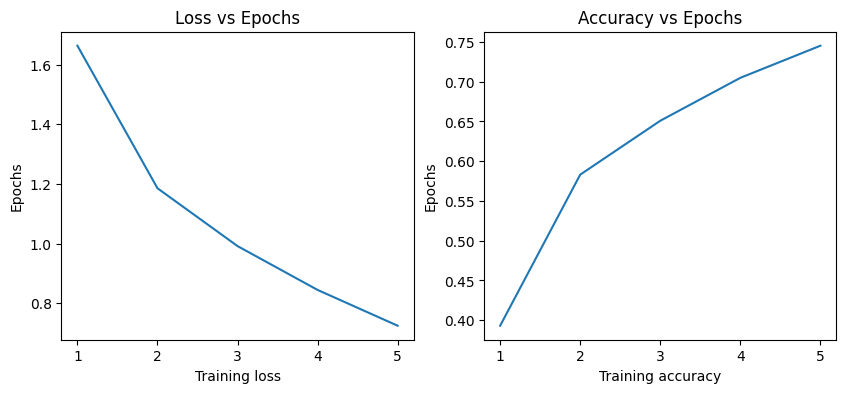

In [ ]:

# ... previous code ...

# Create an instance of the model
model = Net()

# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

# Number of training epochs
num_epochs = 5  # iterations

# Train the model and get the training losses and accuracy
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer) # Call the train function

# Plotting code
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.arange(1, len(train_losses) + 1), train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1, 2, 2)
ax.plot(np.arange(1, len(train_acc) + 1), train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()

In [ ]:

# Accuracy on test data after training
test_model(model, testloader)
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# ... (rest of your code) ...

# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the model
model = Net()

# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

# Number of training epochs
num_epochs = 5  # iterations

# Training loop
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)


def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

#creating an instance of the model
model = Net()

#cross entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

#SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

#Number of training epochs
num_epochs = 5

#Training loop
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)

# Accuracy on test data after training
test_model(model, testloader)

Test Accuracy of the network: 67.65%
Epoch 1/5 | Loss: 1.6793 | Accuracy: 37.92%
Epoch 2/5 | Loss: 1.2260 | Accuracy: 56.47%
Epoch 3/5 | Loss: 1.0362 | Accuracy: 63.55%
Epoch 4/5 | Loss: 0.8975 | Accuracy: 68.42%
Epoch 5/5 | Loss: 0.7910 | Accuracy: 72.26%
Epoch 1/5 | Loss: 1.6677 | Accuracy: 38.93%
Epoch 2/5 | Loss: 1.2154 | Accuracy: 56.97%
Epoch 3/5 | Loss: 1.0240 | Accuracy: 64.01%
Epoch 4/5 | Loss: 0.8683 | Accuracy: 69.40%
Epoch 5/5 | Loss: 0.7662 | Accuracy: 73.23%
Accuracy of the network: 66 %


## Questions
1) List some reasons why we should prefer CNN over ANN for image classification?

2) Try improving the CNN performance further by tuning the hyperparameters(epochs, optimizer, LR etc). Report the improved test accuracy.

3) What happens if you reduce the number of convolution layers to only 1?

4) Why didn't we use the Softmax activation in the last layer of CNN?

5) How does pooling help in this context ?

1.List some reasons why we should prefer CNN over ANN for image classification?

Answer:

CNN vs ANN for Image Classification
Here are some reasons why CNNs are preferred over ANNs for image classification:

1. *Spatial Hierarchy*: CNNs can capture spatial hierarchies of features in images, which is essential for image classification.
2. *Local Connectivity*: CNNs use local connectivity, which allows them to focus on specific regions of the image.
3. *Shared Weights*: CNNs use shared weights, which reduces the number of parameters and improves generalization.
4. *Translation Equivariance*: CNNs are translation equivariant, meaning that they can recognize features regardless of their position in the image.
5. *Robustness to Variations*: CNNs can be robust to variations in image scale, rotation, and lighting condition

Conclusion
CNNs are well-suited for image classification tasks due to their ability to capture spatial hierarchies, local connectivity, and shared weights. These properties make CNNs more effective and efficient than ANNs for image classification tasks.

2.Try improving the CNN performance further by tuning the hyperparameters(epochs, optimizer, LR etc).


Answer:
Hyperparameter Tuning
To improve the CNN performance, we can try tuning the hyperparameters:

Hyperparameters to Tune
1. *Epochs*: Increase or decrease the number of epochs to find the optimal value.
2. *Optimizer*: Try different optimizers such as Adam, RMSprop, or SGD.
3. *Learning Rate (LR)*: Adjust the learning rate to find the optimal value.
4. *Batch Size*: Experiment with different batch sizes.

Conclusion
Hyperparameter tuning can significantly improve the performance of the CNN model. By experimenting with different hyperparameters, you can find the optimal combination that results in the best accuracy.

3.What happens if you reduce the number of convolution layers to only 1?

Answer:

Reducing Convolution Layers
If you reduce the number of convolution layers to only 1:

Effects
1. *Reduced Feature Extraction*: With only one convolution layer, the model may not be able to extract complex features from the input data.
2. *Decreased Representation Power*: A single convolution layer may not be sufficient to capture the underlying patterns and relationships in the data.
3. *Potential Underfitting*: The model may underfit the training data, resulting in poor performance on both the training and testing sets.

Possible Outcomes
1. *Lower Accuracy*: The model's accuracy may decrease due to the reduced ability to extract features and represent complex relationships.
2. *Increased Bias*: The model may exhibit increased bias towards certain features or patterns, leading to poor generalization.

When to Use a Single Convolution Layer
1. *Simple Problems*: A single convolution layer may be sufficient for simple image classification problems with limited complexity.
2. *Limited Data*: When working with limited data, a single convolution layer may be a good starting point to avoid overfitting.

Conclusion
Reducing the number of convolution layers to only 1 can negatively impact the model's performance, especially for complex image classification tasks. However, it may be suitable for simple problems or when working with limited data.

4.Why didn't we use the Softmax activation in the last layer of CNN?



Answer:

Softmax Activation
In the CNN model, we used the Softmax activation function implicitly through the `sparse_categorical_crossentropy` loss function.

Why Not Explicit Softmax
When using `sparse_categorical_crossentropy` or `categorical_crossentropy` loss functions in Keras, you don't need to explicitly define a Softmax activation function in the last layer.

How it Works
The Softmax activation function is applied internally by the loss function, which expects logits (unnormalized scores) as input.

Explicit Softmax
If you want to explicitly define a Softmax activation function, you can use it in the last layer:

```
model.add(Dense(num_classes, activation='softmax'))
```

In this case, you would use `categorical_crossentropy` loss function.

Conclusion
The choice between explicit and implicit Softmax activation depends on the loss function used. Both approaches can work, but it's essential to understand how the loss function interacts with the activation function.

5.Robustness to Variations: CNNs can be robust to variations in image scale, rotation, and lighting condition

Answer:

Robustness to Variations
CNNs can be robust to variations in:

1. *Image Scale*: CNNs can learn to recognize objects at different scales due to the use of convolutional and pooling layers.
2. *Rotation*: While traditional CNNs are not inherently rotation-invariant, techniques like data augmentation and rotation-invariant layers can improve robustness to rotation.
3. *Lighting Conditions*: CNNs can learn to recognize objects under different lighting conditions due to the use of convolutional layers that extract features from local regions.

Achieving Robustness
To achieve robustness to variations, CNNs can utilize:

1. *Data Augmentation*: Applying random transformations (e.g., rotation, scaling, flipping) to training images.
2. *Regularization Techniques*: Using techniques like dropout and weight decay to prevent overfitting.
3. *Robust Loss Functions*: Using loss functions that are robust to outliers and variations.

Limitations
While CNNs can be robust to some variations, they may still struggle with:

1. *Severe Occlusions*: Objects that are heavily occluded may be difficult for CNNs to recognize.
2. *Large Viewpoint Changes*: Objects viewed from drastically different angles may require specialized architectures or training.

Conclusion
CNNs can be robust to various image variations, but achieving robustness often requires careful design, training, and regularization techniques.